In [1]:
import os
import sys
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_settings_v3 import *
from plot_auxiliary import *
from planar import create_proximity_graph
from auxiliary import get_base_network_name
from auxiliary import getLinearReg, powerlaw

%matplotlib inline

net_type = 'DT'
param = 'param'

net_dir = os.path.join('..', 'networks', net_type)

In [2]:
attacks = [
    #'Ran', 'DegU', 
    'BtwU', 'BtwU_cutoff2', 'BtwU_cutoff3','BtwU_cutoff4', #'BtwU_cutoff6', 'BtwU_cutoff7', 
    'BtwU_cutoff8', #'BtwU_cutoff9',
    'BtwU_cutoff15'
]

In [3]:
all_comp_sizes_dict = {}
comp_dist_log = {}
for attack in attacks:
    comp_dist_log[attack] = {}
    all_comp_sizes_dict[attack] = {}

In [4]:
N_per_attack = {
    'BtwU': 8192,
    'BtwU_cutoff2': 8192,
    'BtwU_cutoff3': 8192,
    'BtwU_cutoff4': 8192,
    'BtwU_cutoff6': 8192,
    'BtwU_cutoff7': 8192,
    'BtwU_cutoff8': 8192,
    'BtwU_cutoff9': 8192,
    'BtwU_cutoff15': 8192,
}
#for attack in attacks:
for attack in attacks:
    N = N_per_attack[attack]
    all_comp_sizes_dict[attack][N] = {}   
    comp_dist_log[attack][N] = {}

In [5]:
overwrite = False
all_f_values = {
    #'BtwU': ['0.0435'] # N = 4096
    #'BtwU': ['0.04500', '0.04736', '0.05000', '0.05469'], # N = 2048
    #'BtwU': ['0.02500', '0.03000', '0.03500', '0.03750', '0.04000', '0.04350', '0.05000'], # N = 4096
    'BtwU': [ '0.03000', '0.03250', '0.03500', '0.03750', '0.04000', '0.04250'],#, '0.05000'], # N = 4096
    'DegU': ['0.37354'], # N = 2048
    'Ran': ['0.50977'], # N = 2048
    'BtwU_cutoff2': ['0.30000', '0.31000', '0.32000', '0.33000', '0.34000'], # N = 8192
    'BtwU_cutoff3': ['0.26000', '0.27000', '0.28000', '0.29000', '0.30000'], # N = 8192
    'BtwU_cutoff4': ['0.23000', '0.24000', '0.25000', '0.26000', '0.27000'], # N = 8192
    'BtwU_cutoff6': ['0.18000', '0.19000', '0.20000', '0.21000', '0.22000'], # N = 8192
    'BtwU_cutoff7': ['0.18000', '0.19000', '0.20000', '0.21000'], # N = 8192
    'BtwU_cutoff8': ['0.16000', '0.17000', '0.18000', '0.19000', '0.20000'], # N = 8192
    'BtwU_cutoff9': ['0.15000', '0.16000', '0.17000', '0.18000'], # N = 8192
    'BtwU_cutoff15': ['0.09000', '0.09500', '0.10000', '0.11000'] # N = 8192
}

for attack in attacks:
    print(attack)
    
    gcc = False
    if attack in ['BtwU']:
        gcc = True
    
    N = N_per_attack[attack]
    f_values = all_f_values[attack]
    
    net_dir_name = '../networks/DT/DT_param'.format(param)
    base_net_name = 'DT_param_N{}'.format(N)
    base_net_dir_name = os.path.join(net_dir_name, base_net_name)

    for f_value in f_values:
        print(f_value)
        if f_value in all_comp_sizes_dict[attack][N]:
            continue
        if gcc:
            comp_sizes_file = 'comp_sizes_gcc_{}_f{}.txt'.format(attack, f_value)
        else:
            comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
        full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
        comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
        
        all_comp_sizes_dict[attack][N][f_value] = comp_sizes

BtwU
0.03000
0.03250
0.03500
0.03750
0.04000
0.04250
BtwU_cutoff2
0.30000
0.31000
0.32000
0.33000
0.34000
BtwU_cutoff3
0.26000
0.27000
0.28000
0.29000
0.30000
BtwU_cutoff4
0.23000
0.24000
0.25000
0.26000
0.27000
BtwU_cutoff8
0.16000
0.17000
0.18000
0.19000
0.20000
BtwU_cutoff15
0.09000
0.09500
0.10000
0.11000


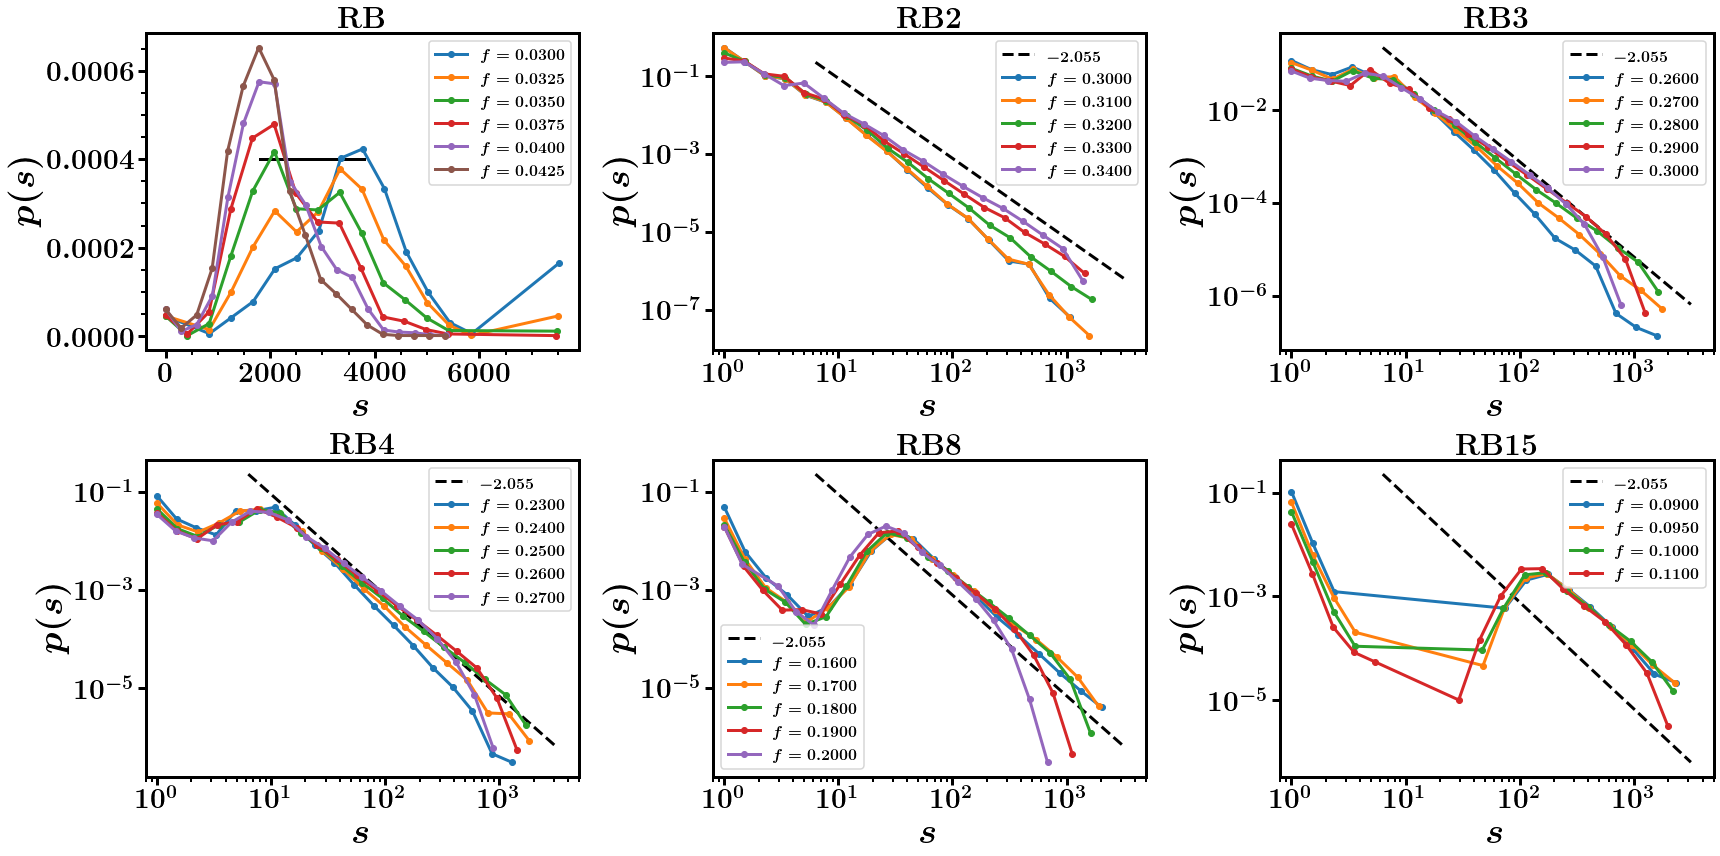

In [13]:
def get_histo(comp_sizes, log=True):
    mask = comp_sizes > 0
    comp_sizes = comp_sizes[mask]     
    min_s = np.min(comp_sizes)
    max_s = np.max(comp_sizes)
    if log:
        bins = np.logspace(np.log10(min_s), np.log10(max_s), 20)
    else:
        bins = np.linspace(min_s, max_s+1, 20)
    hist = np.histogram(comp_sizes, bins=bins, density=True)
    hist_norm = hist[0]
    hist_norm[hist_norm==0] = np.NaN
    mask = ~np.isnan(hist_norm)
    X = bins[:-1]
    X = X[mask]
    Y = hist_norm[mask]

    return X, Y

def plot_comp_sizes(attack, comp_sizes, f_values, ax, log=True):
    for i, f_value in enumerate(f_values):
        X, Y = get_histo(comp_sizes[f_value], log=log)

        label = r'$f={{{:.4f}}}$'.format(float(f_value))
        ax.plot(X, Y, '-' , marker='o', label=label)

    return
            
ylim = (1E-6, 7)
xlim = (0.8, 5000)
ncols = 3
nrows = len(attacks) // ncols + len(attacks) % ncols
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
axes = axes.flatten()
for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlim(xlim)
    #ax.set_ylim(ylim)
    ax.set_xlabel(r'$s$', fontsize=36)
    ax.set_ylabel(r'$p(s)$', fontsize=36)    

for i, attack in enumerate(attacks):
    ax = axes[i]
    ax.set_title(attack_dict[attack], fontsize=30)
    N = N_per_attack[attack]
    f_values = all_f_values[attack]
    log = True
    if attack == 'BtwU':
        log = False
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        
        ax.plot([1800, 3800], [0.0004]*2, color='k')
        ax.autoscale()
        ax.margins(0.05)
    elif 'cutoff' not in attack:
        X = np.logspace(0, 2.5)
        a = -2.055
        #c = Y[0] / X[0]**a
        c = 1
        Y = powerlaw(X, a, c)
        ax.plot(X, Y, '--', color='k', label=r'${{{:.3f}}}$'.format(a))
        
        a = -1.7
        #c = Y[0] / X[0]**a
        c = 1
        Y = powerlaw(X, a, c)
        ax.plot(X, Y, '-.', color='k', label=r'${{{:.3f}}}$'.format(a))
    else:
        X = np.logspace(0.8, 3.5)
        a = -2.055
        #c = Y[0] / X[0]**a
        c = 10
        Y = powerlaw(X, a, c)
        ax.plot(X, Y, '--', color='k', label=r'${{{:.3f}}}$'.format(a))
    plot_comp_sizes(attack, all_comp_sizes_dict[attack][N], f_values, ax, log=log)
    ax.legend(fontsize=16)
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'comp_sizes_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()